In [1]:
#import Pkg; using Pkg

#Pkg.add("Flux")

#Pkg.add("Statistics")
#Pkg.add("ProgressMeter")
#Pkg.add("Plots")

#pkg = Base.PkgId(Base.UUID("76a88914-d11a-5bdc-97e0-2f5a05c973a2"), "CUDA_Runtime_jll")
#Pkg.add("CUDA")
#Pkg.add("cuDNN");

#Pkg.update()

# Pkg.offline(true)

In [3]:
# pkg = Base.PkgId(Base.UUID("76a88914-d11a-5bdc-97e0-2f5a05c973a2"), "CUDA_Runtime_jll")

In [4]:
# import Pkg; Pkg.add("cuDNN"); using cuDNN

In [1]:

using Flux, Statistics, ProgressMeter
using Plots

using CUDA, cuDNN

### Julia Flux: Neural Network in one Minute

Code from 

[https://fluxml.ai/Flux.jl/stable/guide/models/quickstart/#man-quickstart]

Nov 15, 2024




### XOR Problem

The XOR problem is a classic challenge in the field of deep learning. 

+ It highlights the limitations of simple Neural Net structures and demonstrates the need for more complex architectures to learn non-linear patterns. 
 

### What is the problem?

A single-layer perceptron (based on a dense layer, the simplest form of a neural net) cannot solve the XOR problem. 

```
   AND
I1 I2 Out
0  0   0
0  1   0
1  0   0
1  1   1

   OR
I1 I2 Out
0  0   0
0  1   1
1  0   1
1  1   1

   XOR
I1 I2 Out
0  0   0
0  1   1
1  0   1
1  1   0

```

+ As we can see from the truth table, the XOR gate produces a true output only when the inputs are different. 

+ This non-linear relationship between the inputs and the output poses a challenge for single-layer perceptrons, which can only learn linearly separable patterns

### Here's why:   

1. Linear separability: Single-layer perceptrons can only learn linearly separable patterns. This means they can only classify data points by drawing a single straight line to separate them into two categories.   


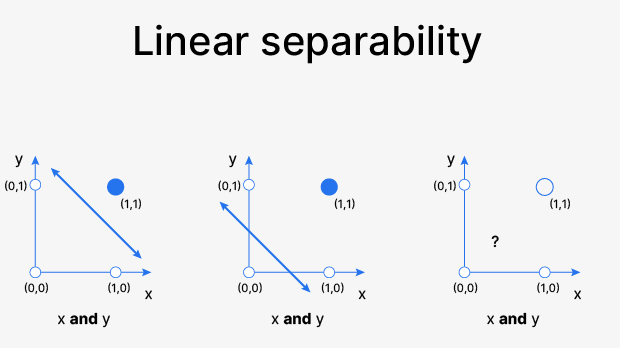


2. Non-linearity of XOR: The XOR function is not linearly separable. We cannot draw a single straight line to correctly separate the '0' outputs from the '1' outputs in the XOR truth table.   

### How is this problem resolved?

1. We need more complexity into the neural network. 

2. This is typically done by adding a hidden layer with non-linear activation functions. 

3. This allows the network to learn more complex, non-linear decision boundaries.   

4. Multi-layer perceptrons (MLPs): with at least one hidden layer can effectively solve the XOR problem.

5. The hidden layer allows the network to learn intermediate representations of the data, which can then be combined to create a non-linear decision boundary.

6. Non-linear activation functions, like *Sigmoid* or *ReLU* introduce the non-linearity needed by the network to enable the model learn more complex patterns.

   
In summary:

1. The XOR problem is a good topic for discussion in neural networks.

2. It demonstrates the limitations of simple perceptrons and the necessity of multi-layered architectures with non-linear activation functions for solving more complex tasks.

3. The XOR problem played a significant role in the development of deep learning by highlighting the importance of network architecture in learning non-linear patterns.   



### A Model with 3 layers

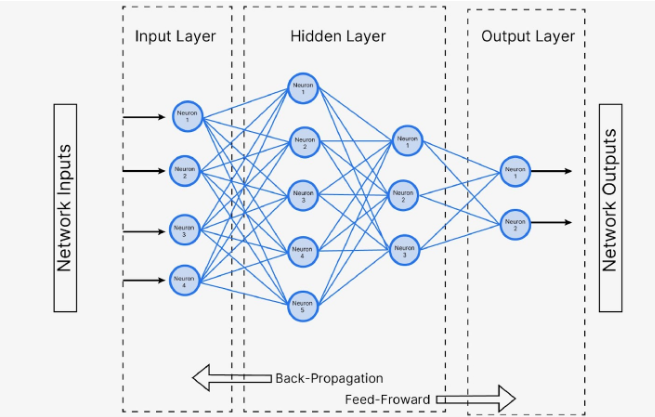

In [8]:
# This will prompt if neccessary to install everything, including CUDA:


# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2)) |> gpu        # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> gpu) |> cpu                                 # 2×1000 Matrix{Float32}
probs1 = softmax(out1)      # normalise to get probabilities

# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.logitcrossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

optim # parameters, momenta and output have all changed
out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)
probs2 = softmax(out2)      # normalise to get probabilities
mean((probs2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


0.965

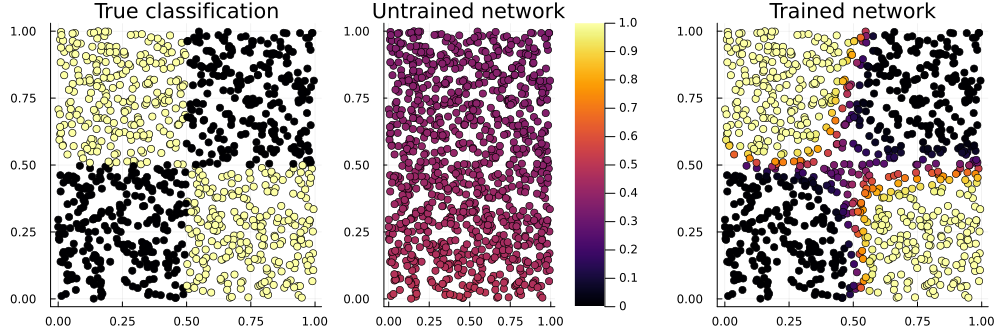

In [4]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=probs1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=probs2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

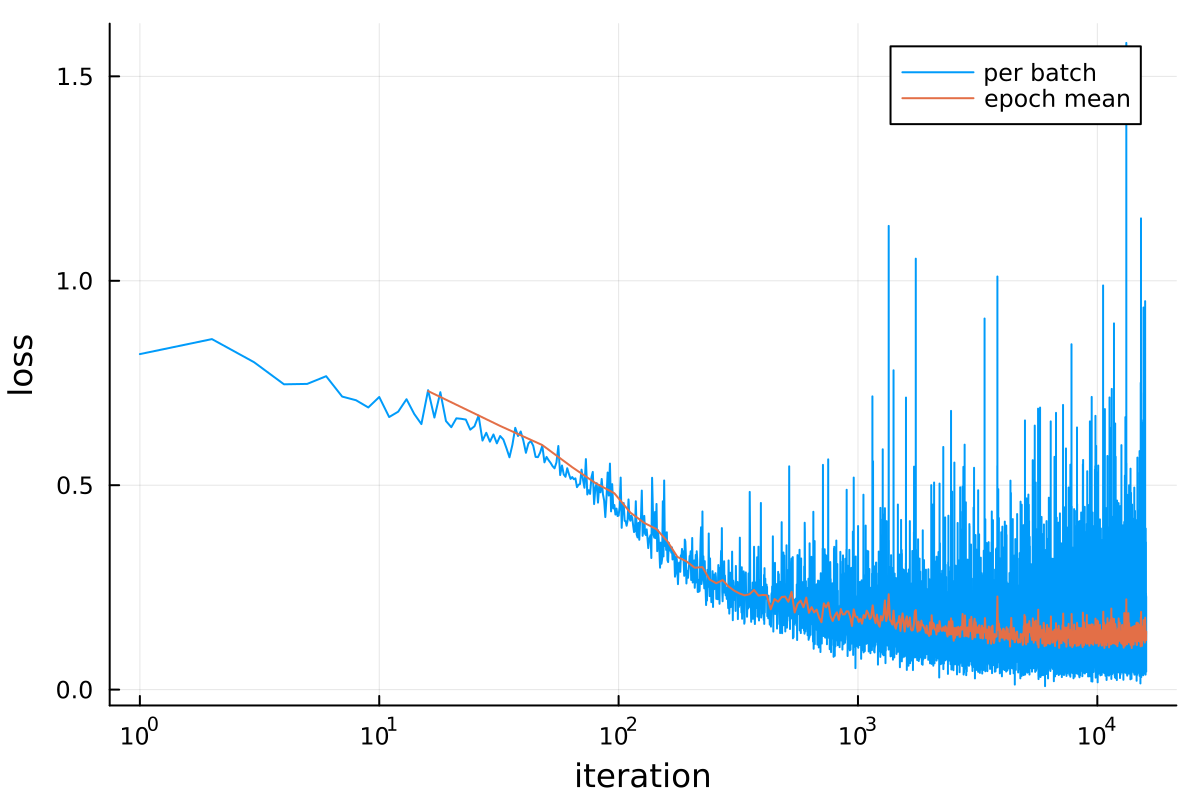

In [5]:
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean", dpi=200)